In [1]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
# import cv2
import pandas as pd

# root_path = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/"
# path_pesi_old = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/pesi/pesi.h5"
save_checkpoints_path = "../model_checkpoints"
# path_root = "/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs"

# class_index = {'Adialer.C': 0,
#                'Agent.FYI': 1,
#                'Allaple.A': 2,
#                'Allaple.L': 3,
#                'Alueron.gen!J': 4,
#                'Autorun.K': 5,
#                'Benign': 6,
#                'C2LOP.P': 7,
#                'C2LOP.gen!g': 8,
#                'Dialplatform.B': 9,
#                'Dontovo.A': 10,
#                'Fakerean': 11,
#                'Instantaccess': 12,
#                'Lolyda.AA1': 13,
#                'Lolyda.AA2': 14,
#                'Lolyda.AA3': 15,
#                'Lolyda.AT': 16,
#                'Malex.gen!J': 17,
#                'Obfuscator.AD': 18,
#                'Rbot!gen': 19,
#                'Skintrim.N': 20,
#                'Swizzor.gen!E': 21,
#                'Swizzor.gen!I': 22,
#                'VB.AT': 23,
#                'Wintrim.BX': 24,
#                'Yuner.A': 25}


train_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\train_combined_malimg.csv")
test_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\test_combined_malimg.csv")
val_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\val_combined_malimg.csv")


In [2]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
    rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    # color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    # color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)
val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    # color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


class_index = train_gen.class_indices

Found 8324 validated image filenames belonging to 26 classes.
Found 1066 validated image filenames belonging to 26 classes.
Found 1031 validated image filenames belonging to 26 classes.


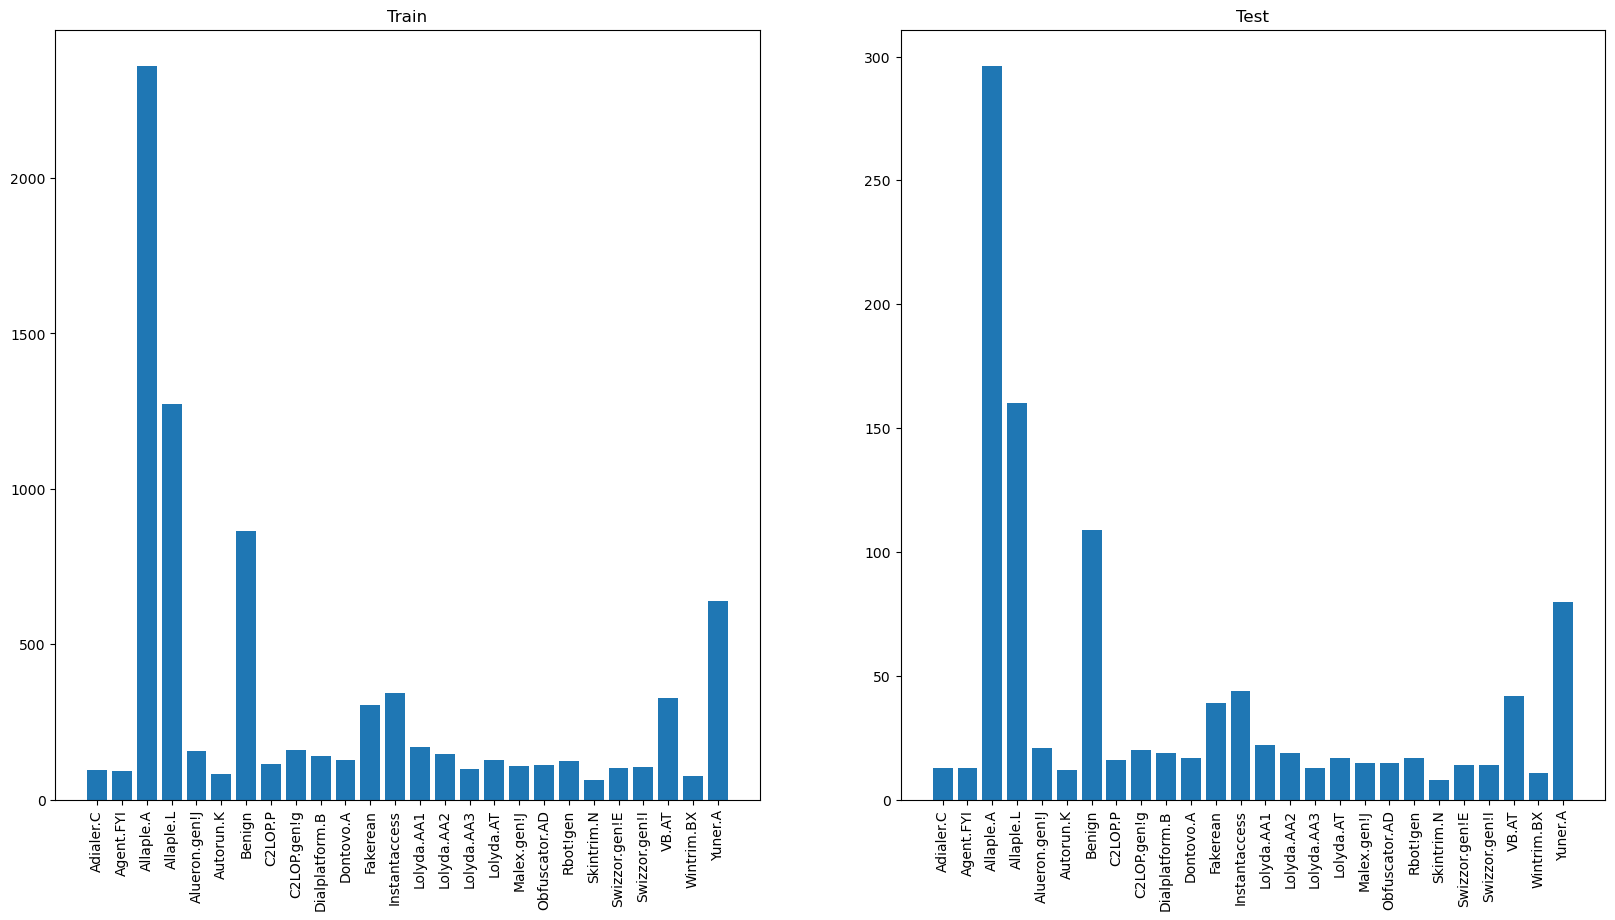

In [3]:
train_occ = train_df.groupby(by="target").size()
test_occ = test_df.groupby(by="target").size()

occur = [train_occ, test_occ]
name = ["Train", "Test"]

plt.figure(figsize=(20, 10))

for i in range(2):

  plt.subplot(1, 2, i+1)
  plt.title(name[i])
  plt.xticks(rotation="vertical")
  plt.bar(class_index.keys(), occur[i])

plt.show()

C:\Users\youssef khaled\AppData\Local\Temp\ipykernel_21024\4246841074.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = train_df.replace({"target": class_index})['target'].to_numpy()


<BarContainer object of 26 artists>

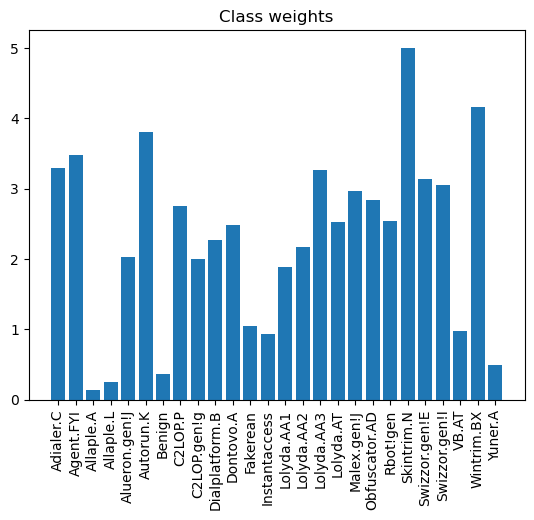

In [4]:

from sklearn.utils import class_weight
train_labels = train_df.replace({"target": class_index})['target'].to_numpy()
class_indices = np.array(list(class_index.values()))

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_indices, y=train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

plt.title("Class weights")
plt.xticks(rotation="vertical")
plt.bar(class_index.keys(), class_weights.values())

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [6]:
num_classes = len(class_index)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model


Malware_model = malware_model()
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [7]:
cp_callback = ModelCheckpoint(
    save_checkpoints_path, verbose=1, monitor="val_accuracy")
# Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

history = Malware_model.fit(train_gen, validation_data=val_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
521/521 [==============================] - ETA: 0s - loss: 2.3212 - accuracy: 0.3537 - weighted_accuracy: 0.3411
Epoch 1: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 96s 167ms/step - loss: 2.3212 - accuracy: 0.3537 - weighted_accuracy: 0.3411 - val_loss: 1.5773 - val_accuracy: 0.7973 - val_weighted_accuracy: 0.7973
Epoch 2/10
521/521 [==============================] - ETA: 0s - loss: 1.0096 - accuracy: 0.6593 - weighted_accuracy: 0.6792
Epoch 2: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 73ms/step - loss: 1.0096 - accuracy: 0.6593 - weighted_accuracy: 0.6792 - val_loss: 0.6196 - val_accuracy: 0.8303 - val_weighted_accuracy: 0.8303
Epoch 3/10
521/521 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.7746 - weighted_accuracy: 0.7810
Epoch 3: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 73ms/step - loss: 0.6745 - accuracy: 0.7746 - weighted_accuracy: 0.7810 - val_loss: 0.3721 - val_accuracy: 0.8206 - val_weighted_accuracy: 0.8206
Epoch 4/10
521/521 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.8245 - weighted_accuracy: 0.8274
Epoch 4: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 72ms/step - loss: 0.5158 - accuracy: 0.8245 - weighted_accuracy: 0.8274 - val_loss: 0.3287 - val_accuracy: 0.8419 - val_weighted_accuracy: 0.8419
Epoch 5/10
521/521 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8441 - weighted_accuracy: 0.8378
Epoch 5: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 72ms/step - loss: 0.4400 - accuracy: 0.8441 - weighted_accuracy: 0.8378 - val_loss: 0.2695 - val_accuracy: 0.8555 - val_weighted_accuracy: 0.8555
Epoch 6/10
521/521 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8648 - weighted_accuracy: 0.8576
Epoch 6: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 72ms/step - loss: 0.3836 - accuracy: 0.8648 - weighted_accuracy: 0.8576 - val_loss: 0.2207 - val_accuracy: 0.8720 - val_weighted_accuracy: 0.8720
Epoch 7/10
521/521 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8688 - weighted_accuracy: 0.8660
Epoch 7: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 72ms/step - loss: 0.3595 - accuracy: 0.8688 - weighted_accuracy: 0.8660 - val_loss: 0.2795 - val_accuracy: 0.8603 - val_weighted_accuracy: 0.8603
Epoch 8/10
521/521 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8748 - weighted_accuracy: 0.8679
Epoch 8: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 72ms/step - loss: 0.3124 - accuracy: 0.8748 - weighted_accuracy: 0.8679 - val_loss: 0.1961 - val_accuracy: 0.9476 - val_weighted_accuracy: 0.9476
Epoch 9/10
520/521 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8918 - weighted_accuracy: 0.8774
Epoch 9: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 38s 72ms/step - loss: 0.2831 - accuracy: 0.8918 - weighted_accuracy: 0.8771 - val_loss: 0.1915 - val_accuracy: 0.9515 - val_weighted_accuracy: 0.9515
Epoch 10/10
521/521 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8915 - weighted_accuracy: 0.8841
Epoch 10: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 37s 72ms/step - loss: 0.3009 - accuracy: 0.8915 - weighted_accuracy: 0.8841 - val_loss: 0.1940 - val_accuracy: 0.9525 - val_weighted_accuracy: 0.9525


In [8]:

# Save the trained model
model_save_path = "./saved/malware_model.h5"  # Path to save the model
Malware_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./saved/malware_model.h5


dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


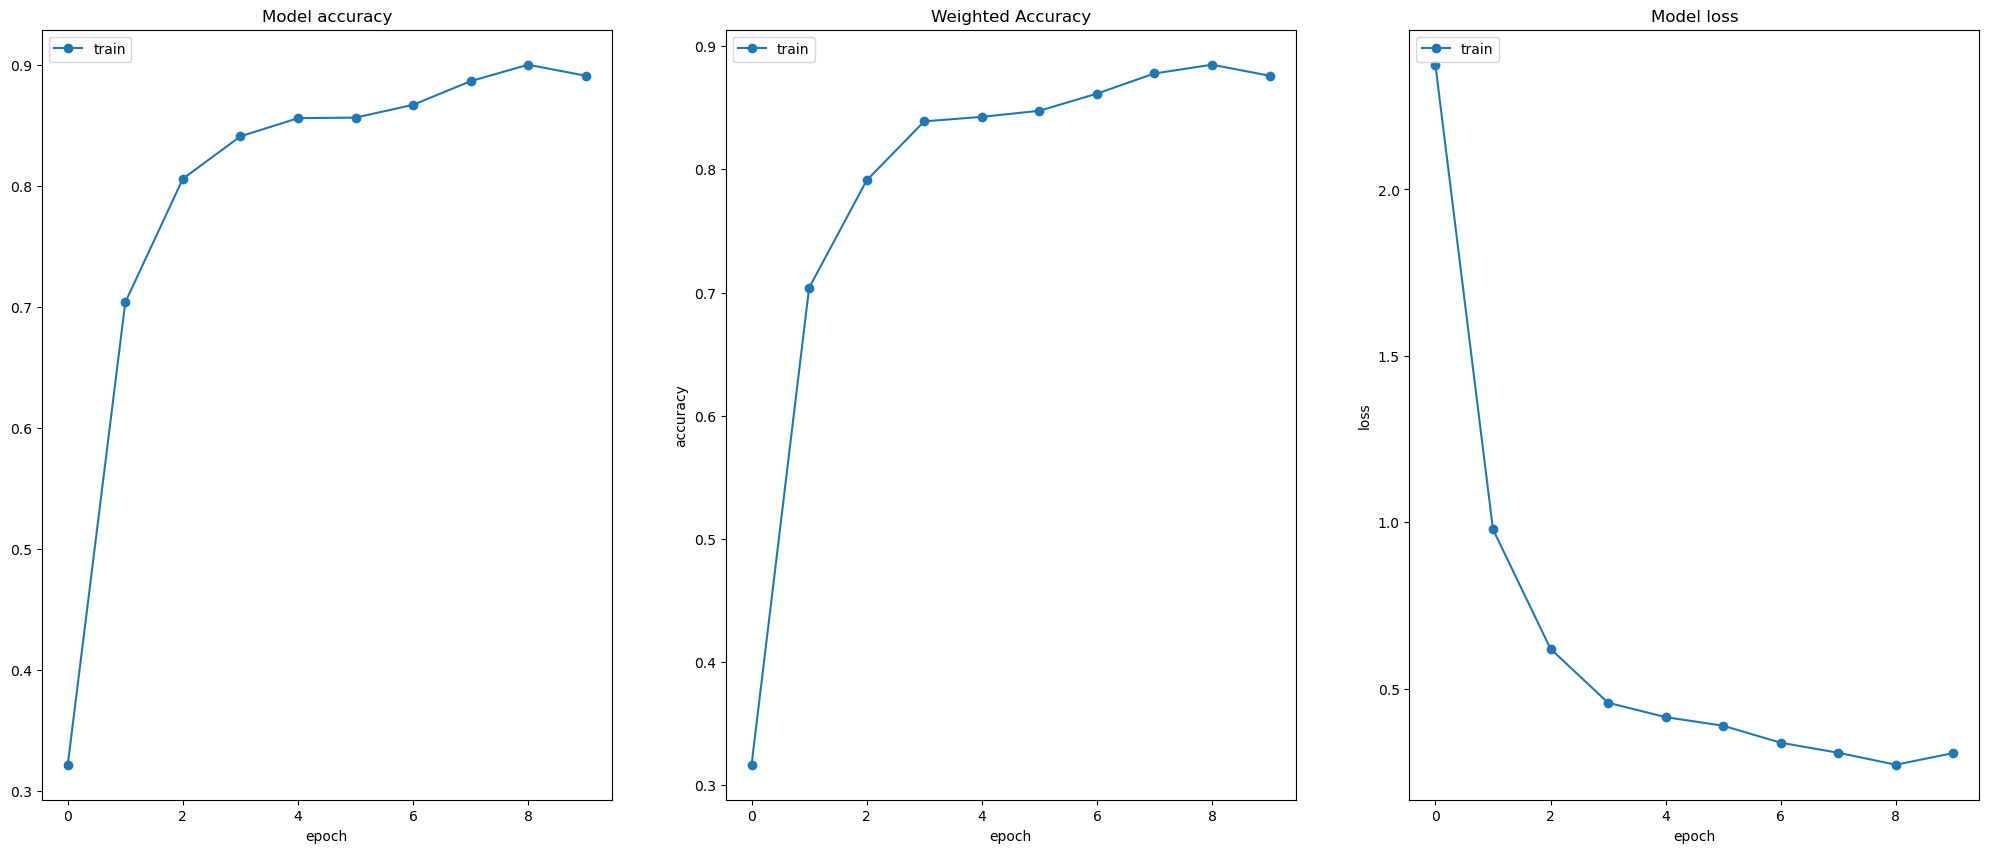

In [9]:
print(history.history.keys())
plt.figure(figsize=(25, 10))
#  "Accuracy"
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], marker='o')
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1, 3, 2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# "Loss"
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [10]:
metric_list = Malware_model.evaluate(test_gen, batch_size=32, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])

67/67 [==============================] - 10s 150ms/step - loss: 0.1838 - accuracy: 0.8959 - weighted_accuracy: 0.8959
evaluate_accuracy=0.896
evaluate_weighted_accuracy=0.896


In [11]:
# from sklearn import metrics

# y_pred = Malware_model.predict(test_gen)
# y_test_predicted = np.argmax(np.array(y_pred), axis=1)
